In [1]:
# 04/20/2022 - Running MGE and JAM on J0037 cleanly

################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from os import path

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from astropy.cosmology import Planck18 as cosmo  # Planck 2018

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_twist import mge_fit_sectors_twist
from mgefit.sectors_photometry_twist import sectors_photometry_twist
from mgefit.mge_print_contours_twist import mge_print_contours_twist

# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from plotbin.plot_velfield import plot_velfield

################################################################

In [2]:
# specify object directory and name

#file_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/CF_mosaics/SDSSJ0037-0942'
file_dir = '/local/shawnknabel/data/CF_mosaics'
obj_name = '/SDSSJ0037-0942'

In [3]:
# functions

def crop_center_image (img, radius, scale, method='center'):
    
    '''
    Takes image, crops at argmax, and returns a 2radius x 2radius square image centered at the lower left corner of the center pixel
    
    img - (n,n) image with nxn pixels
    
    radius - radius in arcsec to which the 
    
    scale - pixel scale (arcsec/pix)
    
    method - str, default 'center' does not recenter, 'argmax' recenters to maximum pixel argument
    '''
    
    # take center pixel
    if method == 'center':
        # take center of input image
        central_pix_x = int(np.floor(img.shape[0]/2))
        central_pix_y = int(np.floor(img.shape[1]/2))
    elif method == 'argmax':
        # take center of image at argmax 
        central_pix = np.unravel_index(np.argmax(img, axis=None), img.shape)
        central_pix_x = central_pix[1]
        central_pix_y = central_pix[0]   
    
    # take radius in pixels
    radius = int(np.around(radius / scale))
    
    # crop to radius
    cropped_img = img[central_pix_y - radius:central_pix_y + radius, central_pix_x - radius:central_pix_x + radius]
    
    return(cropped_img, central_pix_x, central_pix_y)
    


In [4]:
# import image, center, and crop

# effective radius in V band
# take photometry out to 4-5 r_eff
r_eff_V = 2.68

#######################################################################################
# kcwi datacube

file = file_dir + "/KCWI_J0037_icubes_mosaic_0.1457_2Dintegrated.fits"
hdu = fits.open(file)
kcwi_img = hdu[0].data
header = hdu[0].header

plt.clf()
plt.imshow(kcwi_img)
plt.pause(1)

# pixel scale
kcwi_scale = 0.147  # arcsec/pixel r_eff_V

# crop the image to ~ 2 arcsec radius
kcwi_2arc_img, _, _ = crop_center_image(kcwi_img, 2, kcwi_scale, 'argmax')

plt.clf()
plt.imshow(kcwi_2arc_img, origin='lower', extent=[-2,2,-2,2])#, extent=[0,50,0,50])
plt.contour(kcwi_2arc_img, colors='grey', extent=[-2,2,-2,2])
plt.title('KCWI datacube')
plt.pause(1)

#######################################################################################
# F435W cutout

# import image, center, and crop

file = f'/data/end_product/SLACS{obj_name}/cutouts{obj_name}_F435W.fits'
hdu = fits.open(file)
hstF435_img = hdu[0].data
header = hdu[0].header

# pixel scale
hst_scale = 0.0455 # or is it 0.0966 (PC vs WF3)

# crop the image to 2 arcsec
hstF435_2arc_img, _, _  = crop_center_image(hstF435_img, 2, hst_scale, 'center')

plt.clf()
plt.imshow(hstF435_2arc_img, origin='lower', extent=[-2,2,-2,2])
plt.contour(kcwi_2arc_img, colors='grey', extent=[-2,2,-2,2])
plt.contour(hstF435_2arc_img, colors='k', extent=[-2,2,-2,2])
plt.title('HST F435W')
plt.pause(1)

#######################################################################################
# F606W cutout

# import image, center, and crop

file = f'/data/end_product/SLACS/SDSSJ0037-0942/cutouts/{obj_name}_F606W.fits'
hdu = fits.open(file)
hstF606_cutout_img = hdu[0].data
header = hdu[0].header

# crop the image to 2 arcsec
hstF606_2arc_img, _, _  = crop_center_image(hstF606_cutout_img, 2, hst_scale, 'center')

plt.clf()
plt.imshow(hstF606_2arc_img,origin='lower', extent=[-2,2,-2,2])#, extent=[0,50,0,50])
plt.contour(kcwi_2arc_img, colors='grey', extent=[-2,2,-2,2])
plt.contour(hstF606_2arc_img, colors='k', extent=[-2,2,-2,2])
plt.title('HST F606W')
plt.pause(1)

FileNotFoundError: [Errno 2] No such file or directory: '/local/shawnknabel/data/CF_mosaics/KCWI_J0037_icubes_mosaic_0.1457_2Dintegrated.fits'

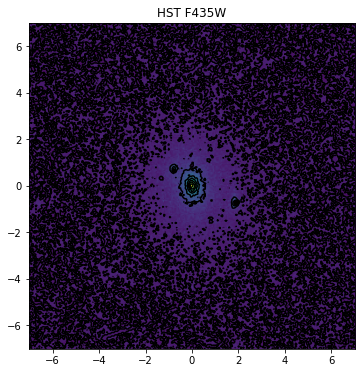

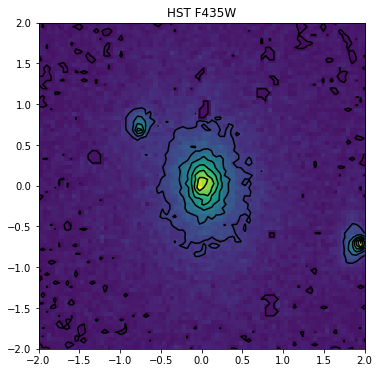

In [17]:
#######################################################################################
# F435W cutout

# import image, center, and crop

file = f'/local/shawnknabel/data/slacs/SLACSJ0037-0942_53266_435_1_biz02.fits'
hdu = fits.open(file)
hstF435_img = hdu[0].data
header = hdu[0].header

# pixel scale
hst_acs_scale = 0.050 # arcesc/pix

img_width = hstF435_img.shape[0]
img_width_arcsec = img_width * hst_acs_scale
half_width = img_width_arcsec/2

plt.clf()
plt.imshow(hstF435_img, origin='lower', extent=[-half_width,half_width,-half_width,half_width])
#plt.contour(kcwi_2arc_img, colors='grey', extent=[-2,2,-2,2])
plt.contour(hstF435_img, colors='k', extent=[-half_width,half_width,-half_width,half_width])
plt.title('HST F435W')
plt.pause(1)

# crop the image to 2 arcsec
hstF435_2arc_img, _, _  = crop_center_image(hstF435_img, 2, hst_acs_scale, 'center')

plt.clf()
plt.imshow(hstF435_2arc_img, origin='lower', extent=[-2,2,-2,2])
#plt.contour(kcwi_2arc_img, colors='grey', extent=[-2,2,-2,2])
plt.contour(hstF435_2arc_img, colors='k', extent=[-2,2,-2,2])
plt.title('HST F435W')
plt.pause(1)

# I'm going to crop the full HST F606 image

In [ ]:
# import image, center, and crop

file = '/data/end_product/SLACS/SDSSJ0037-0942/image/SDSSJ0037-0942_F606W_u9qc89_sci.fits'
hdu = fits.open(file)
hstF606_img = hdu[0].data
header = hdu[0].header

# take the PA of the HST image
hst_PA = hdu[0].header['ORIENTAT']
hst_PA = -hst_PA

# rotate the image by the PA
hstF606_img = rotate(hstF606_img, hst_PA)

# see what wcs center is
#w = WCS(header)
#central_pixel_wcs = w.world_to_pixel(kcwi_center_wcs)
#central_pixel_wcs_x = central_pixel_wcs[0]
#central_pixel_wcs_y = central_pixel_wcs[1]

# take central pixel to be highest intensity
hstF606_centered_img, _, _  = crop_center_image(hstF606_img, hstF606_img.shape[0], hst_scale, 'center')

#plt.clf()
#plt.imshow(hstF606_img)
#plt.plot(central_pix_x, central_pix_y, 'ro', label='argmax center')
#plt.plot(central_pixel_wcs_x, central_pixel_wcs_y, 'go', label='wcs center')
#plt.legend()
plt.pause(1)

########################################################

# crop to 10 arcsec
hstF606_10arc_img, _, _  = crop_center_image(hstF606_img, 10, hst_scale, 'argmax')

# plot
left, right, upper, lower = [-10,10,-10,10]
plt.clf()
plt.imshow(hstF606_10arc_img, origin='lower', extent=[left, right, upper, lower])#, extent=[0,50,0,50])
#plt.plot(central_pix_x, central_pix_y, 'ro')
#plt.contour(kcwi_img, colors='grey', extent=[left, right, upper, lower])
#plt.contour(hstF606_img, colors='k', extent=[left, right, upper, lower])
plt.title('HST F606W')
plt.pause(1)

########################################################

# crop to 5 arcsec
hstF606_5arc_img, _, _  = crop_center_image(hstF606_img, 5, hst_scale, 'argmax')

# plot
left, right, upper, lower = [-5,5,-5,5]
plt.clf()
plt.imshow(hstF606_5arc_img, origin='lower', extent=[left, right, upper, lower])#, extent=[0,50,0,50])
#plt.plot(central_pix_x, central_pix_y, 'ro')
#plt.contour(kcwi_img, colors='grey', extent=[left, right, upper, lower])
#plt.contour(hstF606_img, colors='k', extent=[left, right, upper, lower])
plt.title('HST F606W')
plt.pause(1)

# First try to get photometry with 10 arcsec image

In [ ]:
# sky, psf, scale, etc.

img = hstF606_10arc_img
scale = hst_scale

'''
I don't have a good selection for this? I'm guessing it's really like the noise level?
'''
minlevel = 0  # counts/pixel 
seeing_fwhm = 0.1 # arcsec
sigmapsf = seeing_fwhm / scale / 2.355 # pixels, 2.355 is fwhm/sigma

############################################################################################################################
# figure out the pixel fraction best to use

# take different values of pixel fractions
lower, upper, steps = (0.06, 0.12, 7)
fractions = np.linspace(lower, upper, steps)
    
eps_list = []
theta_list = []
cen_y_list = [] # don't need these, already centered it
cen_x_list = []

for frac in fractions:
    #print(f'Calculating fraction {frac}')
    frac = np.around(frac, 2)
    mid = np.around((upper+lower)/2, 2)
    plt.clf()
    #plt.clf()
    f = find_galaxy(img, fraction=frac, plot=1, quiet=True)
    eps = f.eps
    theta = f.theta
    cen_y = f.ypeak
    cen_x = f.xpeak
    # assign to lists
    eps_list.append(eps)
    theta_list.append(theta)
    cen_y_list.append(cen_y)
    cen_x_list.append(cen_x)
    plt.title(f'{frac}')
    plt.pause(1)


# The lensed images have a large effect on the PA and ellipticity

In [ ]:
# Take fraction 0.06 to see what it will do.

frac=0.06

#################################################
# Model the central light ellipse

plt.clf()
#plt.clf()
f = find_galaxy(img, fraction=frac, plot=1, quiet=True)
eps = f.eps
theta = f.theta
cen_y = f.ypeak
cen_x = f.xpeak
plt.title(f'{frac}')
plt.pause(1)

################################################
# Perform galaxy photometry

plt.clf()
s = sectors_photometry(img, eps, theta, cen_x, cen_y,
                       minlevel=minlevel, plot=1)
plt.pause(1)  # Allow plot to appear on the screen


# Let's try 5 arcsec and see if we can extract the photometry by only focusing the first fit on the center

In [ ]:
# sky, psf, scale, etc.
# use central ~ 5 arcsec for the galaxy ellipticity and PA

img = hstF606_5arc_img
scale = hst_scale

'''
I don't have a good selection for this? I'm guessing it's really like the noise level?
'''

#print(sigma_psf)

############################################################################################################################

# Here we use FIND_GALAXY directly inside the procedure. Usually you may want
# to experiment with different values of the FRACTION keyword, before adopting
# given values of Eps, Ang, Xc, Yc.

# take different values of pixel fractions
lower, upper, steps = (0.01, 0.06, 7)
fractions = np.linspace(lower, upper, steps)
    
eps_list = []
theta_list = []
#cen_y_list = [] # don't need these, already centered it
#cen_x_list = []

for frac in fractions:
    #print(f'Calculating fraction {frac}')
    frac = np.around(frac, 2)
    mid = np.around((upper+lower)/2, 2)
    plt.clf()
    #plt.clf()
    f = find_galaxy(img, fraction=frac, plot=1, quiet=True)
    eps = f.eps
    theta = f.theta
    #cen_y = f.ypeak
    #cen_x = f.xpeak
    # assign to lists
    eps_list.append(eps)
    theta_list.append(theta)
    #cen_y_list.append(cen_y)
    #cen_x_list.append(cen_x)
    plt.title(f'{frac}')
    plt.pause(1)


In [ ]:
# Take fraction 0.01 to see what it will do.

frac=0.01

#################################################
# Model the central light ellipse

plt.clf()
#plt.clf()
f = find_galaxy(img, fraction=frac, plot=1, quiet=True)
eps = f.eps
theta = f.theta
cen_y = f.ypeak
cen_x = f.xpeak
plt.title(f'{frac}')
plt.pause(1)

################################################
# Perform galaxy photometry

plt.clf()
s = sectors_photometry(img, eps, theta, cen_x, cen_y,
                       minlevel=minlevel, plot=1)
plt.pause(1)  # Allow plot to appear on the screen


In [ ]:
############################################################################################################################

# Do the actual MGE fit
# *********************** IMPORTANT ***********************************
# For the final publication-quality MGE fit one should include the line
# "from mge_fit_sectors_regularized import mge_fit_sectors_regularized"
# at the top of this file, rename mge_fit_sectors() into
# mge_fit_sectors_regularized() and re-run the procedure.
# See the documentation of mge_fit_sectors_regularized for details.
# *********************************************************************

# select number of gaussians to fit
ngauss = 12
# We'll need exposure time
hdul = fits.open('/data/end_product/SLACS/SDSSJ0037-0942/image/SDSSJ0037-0942_F606W_u9qc89_sci.fits')
hdu = hdul[0]
exp_time = hdu.header['EXPTIME']

# fit and plot
plt.clf()
m = mge_fit_sectors(s.radius, s.angle, s.counts, eps,
                    ngauss=ngauss, sigmapsf=sigmapsf, #normpsf=normpsf,
                    scale=scale, plot=1, bulge_disk=0, linear=0)
plt.pause(1) 

#############################################################################
# take the outputs

# convert sigma from pixels to arcsec
sigma_pix = m.sol[1]
sigma = sigma_pix * scale

# q 
q = m.sol[2]

# deviations
absdev = m.absdev

# surface brightness
total_counts = m.sol[0]
# calculate peak surface brightness of each gaussian
peak_surf_br = total_counts/(2*np.pi*q*sigma_pix**2)
# correct for extinction and change to surface density
#### 4/19/22 I don't know where I got this surface brightness and extinction stuff...
# convert to johnson i band
# Here 20.840 is the photometric zeropint, 0.1 is a correction for infinite aperture to be applied 
# for surface brightness measurements, and AI is the extinction in the I-band
# dust extinction ~ 0.05 from https://irsa.ipac.caltech.edu/workspace/TMP_lFD64I_6198/DUST/SDSSJ0037-0942.v0002/extinction.html
AI = 0.05
iband_surf_br = 20.840 + 0.1 + 5 * np.log10(scale) + 2.5 * np.log10(exp_time) - 2.5 * np.log10(peak_surf_br) - AI
# convert to surface density (L_sol_I pc−2)
M_sol_I = 4.08
surf_density = (64800/np.pi)**2 * 10**( 0.4 * (M_sol_I - iband_surf_br))



In [ ]:
# Plot the results

# kinematics are to ~ 3 arcsec

n = int(np.around(3/scale))
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
img_3arc = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]
plt.subplot(122)
mge_print_contours(img_3arc, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(img, 
           origin='lower',
           extent = [-3, 3, -3, 3],
          alpha=0.7)
plt.pause(1)  # Allow plot to appear on the screen

n = int(np.around(2/scale))
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
img_2arc = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]
plt.subplot(122)
mge_print_contours(img_2arc, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(img, 
           origin='lower',
           extent = [-2, 2, -2, 2],
          alpha=0.7)
plt.pause(1)  # Allow plot to appear on the screen


n = int(np.around(1/scale))
img_cen = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
plt.subplot(122)
mge_print_contours(img_cen, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(img_cen, 
           origin='lower',
           extent = [-1, 1, -1, 1],
          alpha=0.7)
plt.pause(1)  # Allow plot to appear on the screen
    


___________________

# Try out JAM model



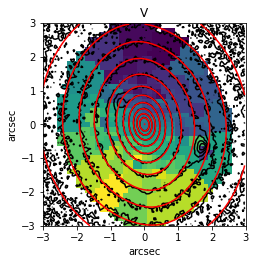

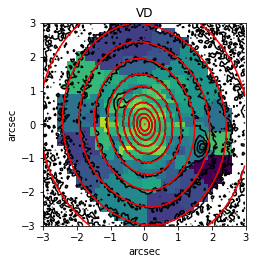

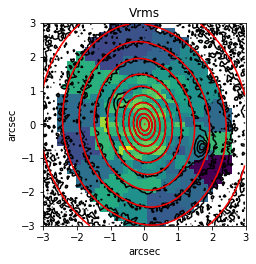

In [12]:
# read in kinematics files for view (3 arcsec, 21 pixels)

# velocity
V = np.genfromtxt(file_dir + obj_name + '_V_2d.txt', delimiter=',')
# find barycenter velocity (intrinsic velocity)
center_axis_index = int(np.floor(V.shape[0]/2))
Vbary = V[center_axis_index, center_axis_index]
V = V - Vbary

# velocity dispersion
VD = np.genfromtxt(file_dir + obj_name + '_VD_2d.txt', delimiter=',')

# uncertainties
dV = np.genfromtxt(file_dir + obj_name + '_dV_2d.txt', delimiter=',')
dVD = np.genfromtxt(file_dir + obj_name + '_dVD_2d.txt', delimiter=',')

# rms velocity
Vrms = np.sqrt(V**2 + VD**2)
dVrms = np.sqrt((dV*V)**2 + (dVD*VD)**2)/Vrms

# show each with surface brightness contours
# at three arcsec
n = int(np.around(3/scale))
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
img_3arc = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]

# V
plt.clf()
plt.subplot(122)
mge_print_contours(img_3arc, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(V, 
           extent = [-3, 3, -3, 3],
           origin='lower',
          alpha=1)
plt.title('V')
plt.pause(1)  # Allow plot to appear on the screen

# VD
plt.clf()
plt.subplot(122)
mge_print_contours(img_3arc, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(VD, 
           extent = [-3, 3, -3, 3],
           origin='lower',
          alpha=1)
plt.title('VD')
plt.pause(1)  # Allow plot to appear on the screen

# Vrms
plt.clf()
plt.subplot(122)
mge_print_contours(img_3arc, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(Vrms, 
           extent = [-3, 3, -3, 3],
           origin='lower',
          alpha=1)
plt.title('Vrms')
plt.pause(1)  # Allow plot to appear on the screen



# This is pretty, but we need it by bins, not by pixel.

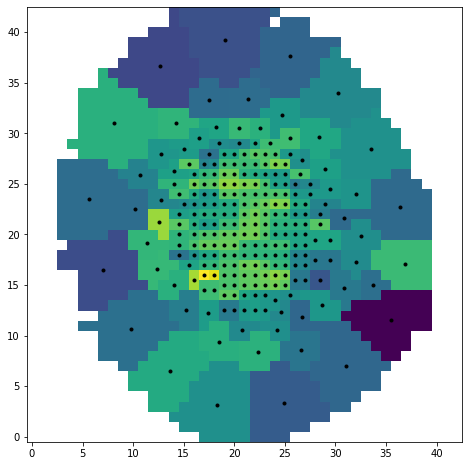

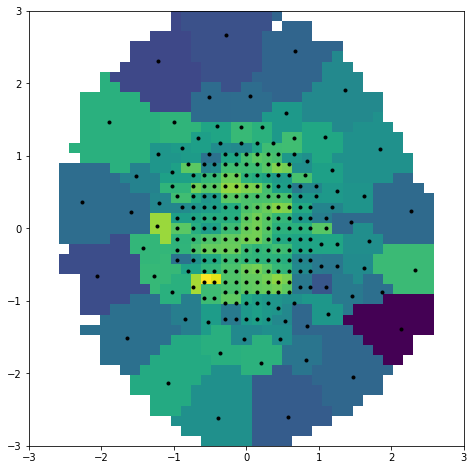

In [13]:
# bring in the velocity measurements and voronoi binning info

vel_meas = np.genfromtxt(file_dir + '/VD.txt') # Array with columns 0-3 - Vel, sigma, dv, dsigma
bins = np.arange(len(vel_meas))
V_bin = vel_meas[:,0]
V_bin = V_bin - Vbary # correct to barycenter velocity
VD_bin = vel_meas[:,1]
dV_bin = vel_meas[:,2]
dVD_bin = vel_meas[:,3]
Vrms_bin = np.sqrt(V_bin**2 + VD_bin**2)
dVrms_bin = np.sqrt((dV_bin*V_bin)**2 + (dVD_bin*VD_bin)**2)/Vrms_bin

# bring in vor_bins x, y, bin
vor_bins = np.genfromtxt(file_dir + '/voronoi_2d_binning_KCWI_J0037_icubes_mosaic_0.1457_output.txt')
vor_bins_df = pd.DataFrame(vor_bins, columns=['x','y','bins'])

# loop through all bins and attach central bins
x_cen_bins = []
y_cen_bins = []

for bins in bins:
    
    # take all x and y in this bin
    xs = vor_bins_df[vor_bins_df.bins==bins]['x']
    ys = vor_bins_df[vor_bins_df.bins==bins]['y']
  
    # take mean of these coords
    x_mean = np.mean(xs)
    y_mean = np.mean(ys)
    
    x_cen_bins.append(x_mean)
    y_cen_bins.append(y_mean)

# convert to arrays    
x_cen_bins = np.array(x_cen_bins)
y_cen_bins = np.array(y_cen_bins)

# center
xbin_00 = x_cen_bins - center_axis_index
ybin_00 = y_cen_bins - center_axis_index

# convert to arcsec # kcwi!
xbin_arcsec = xbin_00 * kcwi_scale
ybin_arcsec = ybin_00 * kcwi_scale

# plot with pixels first
plt.figure(figsize=(8,8))
plt.imshow(Vrms, origin='lower')
plt.scatter(x_cen_bins, y_cen_bins, color='k', marker='.')

# plot with arcsec
extent = [-3,3,-3,3]
plt.figure(figsize=(8,8))
plt.imshow(Vrms, origin='lower', extent=extent)
plt.scatter(xbin_arcsec, ybin_arcsec, color='k', marker='.')

# Hmmm... The center bins are not perfect here because the image isn't exactly 3x3 arcsec

<Figure size 576x432 with 0 Axes>

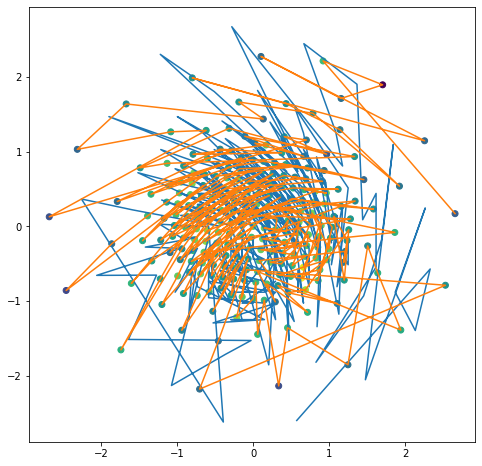

In [14]:
'''
Rotate x and y bins by PA
'''

# set PA from mean photometry fitting
PA = theta

xbin = np.zeros(len(xbin_arcsec))
ybin = np.zeros(len(ybin_arcsec))
    
# rotate the coordinates and append to array
for i in range(len(xbin_arcsec)):
    xbin[i], ybin[i] = rotate_points(xbin_arcsec[i], ybin_arcsec[i], PA) 

plt.clf()
plt.figure(figsize=(8,8))
plt.plot(xbin_arcsec, ybin_arcsec)
plt.plot(xbin, ybin)
plt.scatter(xbin,ybin,c=Vrms_bin)
plt.pause(1)
plt.pause(1)

<Figure size 576x432 with 0 Axes>

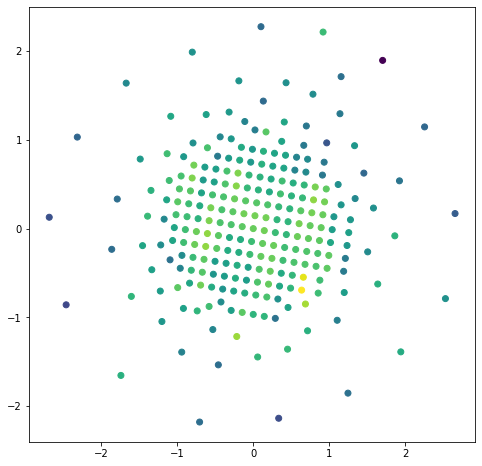

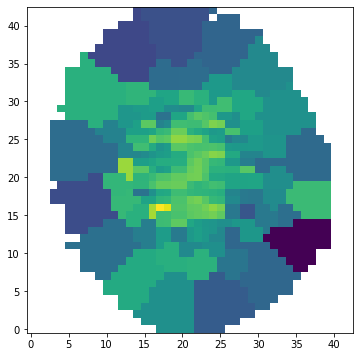

In [15]:
# compare this to the 2d map of vrms

# plot bins
plt.clf()
plt.figure(figsize=(8,8))
plt.scatter(xbin,ybin,c=Vrms_bin)
plt.pause(1)

# plot vrms map
plt.clf()
plt.imshow(Vrms, origin='lower')
plt.pause(1)

# Time for JAM! :)

####################################################
####################################################
Modeling moment zz
####################################################
Inclination of 30 degrees
This inclination does not work
####################################################
Inclination of 40 degrees
This inclination does not work
####################################################
Inclination of 50 degrees
This inclination does not work
####################################################
Inclination of 60 degrees
This inclination does not work
####################################################
Inclination of 70 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.82
inc=70.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.29
Total mass MGE (MSun): 6.115e+11


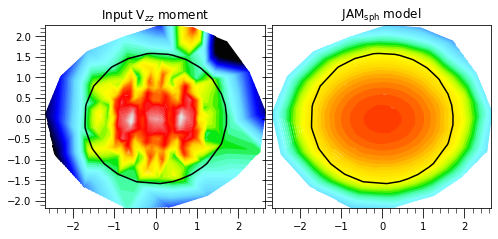

####################################################
Inclination of 80 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.75
inc=80.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.28
Total mass MGE (MSun): 6.112e+11


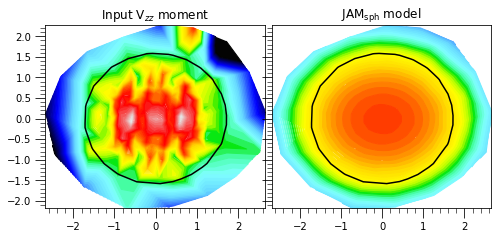

####################################################
Inclination of 90 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.72
inc=90.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.27
Total mass MGE (MSun): 6.111e+11


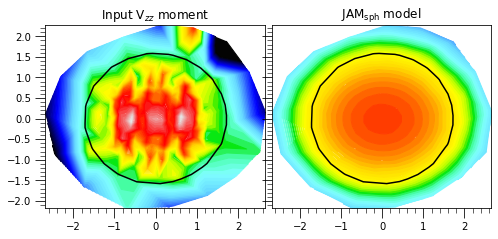

<Figure size 576x432 with 0 Axes>

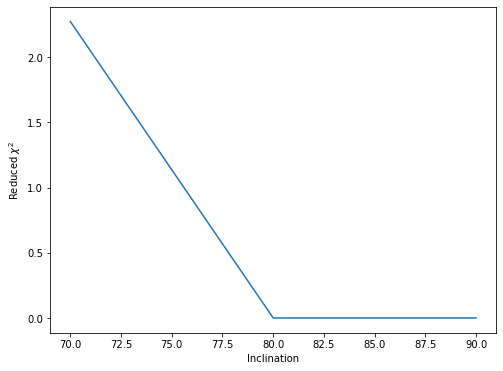

####################################################
####################################################
Modeling moment z
####################################################
Inclination of 30 degrees
This inclination does not work
####################################################
Inclination of 40 degrees
This inclination does not work
####################################################
Inclination of 50 degrees
This inclination does not work
####################################################
Inclination of 60 degrees
This inclination does not work
####################################################
Inclination of 70 degrees
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.86
inc=70.0; beta[0]=0.20; kappa=2.22; M/L=1.00; BH=1.0e+08; chi2/DOF=4.84
Total mass MGE (MSun): 1.977e+11


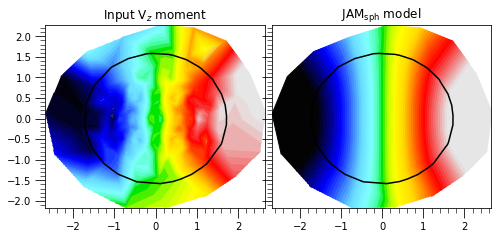

####################################################
Inclination of 80 degrees
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.72
inc=80.0; beta[0]=0.20; kappa=2.42; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


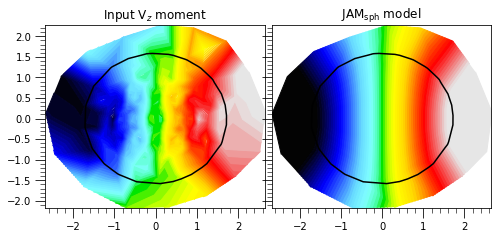

####################################################
Inclination of 90 degrees
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.71
inc=90.0; beta[0]=0.20; kappa=2.49; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


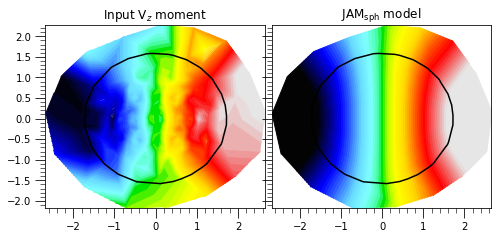

<Figure size 576x432 with 0 Axes>

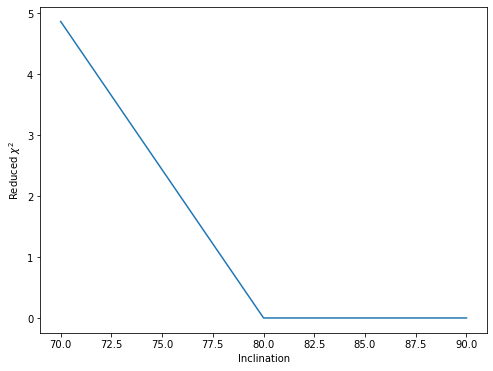

In [20]:

##############################################################################


'''
What do I do for inclination?
'''
inclinations = np.arange(30,95,10)          # Assumed galaxy inclination
        
# take the surface density, etc from mge
surf = surf_density
sigma = sigma
qObs = q

# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value
'''
What do I do for black hole mass?
'''
mbh = 1e8 # Black hole mass in solar masses # not sure what to do here

# try different beta # TBD
#beta_list = [0.1,0.2,0.3,0.4,0.5]
beta = np.full_like(surf, 0.2)

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C
surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs
sigmapsf = sigmapsf
#normpsf = [0.7, 0.3]
'''
Is pixsize just the pixel scale?
'''
pixsize = hst_scale #0.8
goodbins = None

#############################################################
# It's time to JAM now!

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):
    
    print('####################################################')
    print('####################################################')
    print(f'Modeling moment {moment}')
    reduced_chi_squared = np.zeros((len(inclinations)))
    accepted_inclinations = np.copy(inclinations)
    i=0
    for inc in inclinations:
        print('####################################################')
        print(f'Inclination of {inc} degrees')

        inc_rad = np.radians(inc)
        qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
        if np.any(qintr_lum <= 0):
            print('This inclination does not work')
            accepted_inclinations = accepted_inclinations[1:]
            reduced_chi_squared = reduced_chi_squared[:-1]
            continue

        # The model is by design similar but not identical to the adopted kinematics!
        m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                         inc, mbh, distance, xbin, ybin, plot=True, data=data, errors=errors,
                         sigmapsf=sigmapsf, #normpsf=normpsf,
                         beta=beta, pixsize=pixsize,
                         moment=moment, goodbins=goodbins, 
                         align='sph', ml=None, nodots=True)
        plt.pause(3)
        plt.figure(2)
        #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
        reduced_chi_squared[i] = m.chi2
        i = i+1
    
    # plot the inclinations
    plt.clf()
    fig, axs = plt.subplots()
    axs.plot(accepted_inclinations, reduced_chi_squared)
    axs.set_ylabel(r'Reduced $\chi^2$')
    axs.set_xlabel('Inclination')
    plt.pause(1)

####################################################
####################################################
Modeling moment zz
####################################################
Inclination of 30 degrees
This inclination does not work
####################################################
Inclination of 40 degrees
This inclination does not work
####################################################
Inclination of 50 degrees
This inclination does not work
####################################################
Inclination of 60 degrees
This inclination does not work
####################################################
Inclination of 70 degrees
############
Beta of 0.1
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.85
inc=70.0; beta[0]=0.10; kappa=1.00; M/L=3.14; BH=3.1e+08; chi2/DOF=2.37
Total mass MGE (MSun): 6.211e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.87
inc=70.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.29
Total mass MGE (MSun): 6.115e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.86
inc=70.0; beta[0]=0.30; kappa=1.00; M/L=3.04; BH=3.0e+08; chi2/DOF=2.21
Total mass MGE (MSun): 6.009e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.88
inc=70.0; beta[0]=0.40; kappa=1.00; M/L=2.98; BH=3.0e+08; chi2/DOF=2.13
Total mass MGE (MSun): 5.894e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 2.08
inc=70.0; beta[0]=0.50; kappa=1.00; M/L=2.92; BH=2.9e+08; chi2/DOF=2.06
Total mass MGE (MSun): 5.770e+11


<Figure size 576x432 with 0 Axes>

####################################################
Inclination of 80 degrees
############
Beta of 0.1
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.66
inc=80.0; beta[0]=0.10; kappa=1.00; M/L=3.14; BH=3.1e+08; chi2/DOF=2.36
Total mass MGE (MSun): 6.211e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.76
inc=80.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.28
Total mass MGE (MSun): 6.112e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.78
inc=80.0; beta[0]=0.30; kappa=1.00; M/L=3.04; BH=3.0e+08; chi2/DOF=2.20
Total mass MGE (MSun): 6.005e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.78
inc=80.0; beta[0]=0.40; kappa=1.00; M/L=2.98; BH=3.0e+08; chi2/DOF=2.12
Total mass MGE (MSun): 5.889e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 2.01
inc=80.0; beta[0]=0.50; kappa=1.00; M/L=2.91; BH=2.9e+08; chi2/DOF=2.06
Total mass MGE (MSun): 5.762e+11


<Figure size 576x432 with 0 Axes>

####################################################
Inclination of 90 degrees
############
Beta of 0.1
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.72
inc=90.0; beta[0]=0.10; kappa=1.00; M/L=3.14; BH=3.1e+08; chi2/DOF=2.35
Total mass MGE (MSun): 6.210e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.73
inc=90.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.27
Total mass MGE (MSun): 6.111e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.69
inc=90.0; beta[0]=0.30; kappa=1.00; M/L=3.04; BH=3.0e+08; chi2/DOF=2.20
Total mass MGE (MSun): 6.002e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.83
inc=90.0; beta[0]=0.40; kappa=1.00; M/L=2.98; BH=3.0e+08; chi2/DOF=2.12
Total mass MGE (MSun): 5.886e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.99
inc=90.0; beta[0]=0.50; kappa=1.00; M/L=2.91; BH=2.9e+08; chi2/DOF=2.06
Total mass MGE (MSun): 5.761e+11


<Figure size 576x432 with 0 Axes>

####################################################
####################################################
Modeling moment z
####################################################
Inclination of 30 degrees
This inclination does not work
####################################################
Inclination of 40 degrees
This inclination does not work
####################################################
Inclination of 50 degrees
This inclination does not work
####################################################
Inclination of 60 degrees
This inclination does not work
####################################################
Inclination of 70 degrees
############
Beta of 0.1
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.84
inc=70.0; beta[0]=0.10; kappa=1.79; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.85
inc=70.0; beta[0]=0.20; kappa=2.22; M/L=1.00; BH=1.0e+08; chi2/DOF=4.84
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.81
inc=70.0; beta[0]=0.30; kappa=3.16; M/L=1.00; BH=1.0e+08; chi2/DOF=4.81
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.90
inc=70.0; beta[0]=0.40; kappa=5.83; M/L=1.00; BH=1.0e+08; chi2/DOF=4.84
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 2.05
inc=70.0; beta[0]=0.50; kappa=26.9; M/L=1.00; BH=1.0e+08; chi2/DOF=5.69
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

####################################################
Inclination of 80 degrees
############
Beta of 0.1
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.73
inc=80.0; beta[0]=0.10; kappa=1.88; M/L=1.00; BH=1.0e+08; chi2/DOF=4.87
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.76
inc=80.0; beta[0]=0.20; kappa=2.42; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.76
inc=80.0; beta[0]=0.30; kappa=3.79; M/L=1.00; BH=1.0e+08; chi2/DOF=4.84
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.82
inc=80.0; beta[0]=0.40; kappa=11.0; M/L=1.00; BH=1.0e+08; chi2/DOF=5.01
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 2.00
inc=80.0; beta[0]=0.50; kappa=2.57e+03; M/L=1.00; BH=1.0e+08; chi2/DOF=12.2
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

####################################################
Inclination of 90 degrees
############
Beta of 0.1
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.73
inc=90.0; beta[0]=0.10; kappa=1.90; M/L=1.00; BH=1.0e+08; chi2/DOF=4.87
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.67
inc=90.0; beta[0]=0.20; kappa=2.49; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.74
inc=90.0; beta[0]=0.30; kappa=4.08; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.83
inc=90.0; beta[0]=0.40; kappa=15.2; M/L=1.00; BH=1.0e+08; chi2/DOF=5.17
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.99
inc=90.0; beta[0]=0.50; kappa=2.67e+03; M/L=1.00; BH=1.0e+08; chi2/DOF=12.1
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

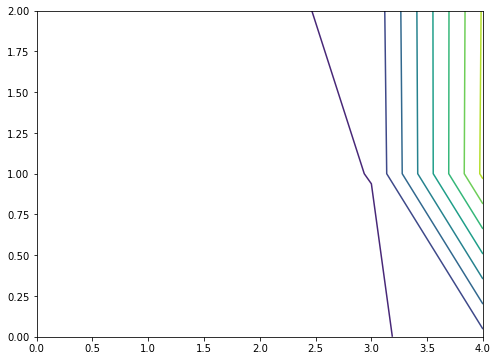

In [22]:



##############################################################################


'''
What do I do for inclination?
'''
inclinations = np.arange(30,95,10)          # Assumed galaxy inclination
        
# take the surface density, etc from mge
surf = surf_density
sigma = sigma
qObs = q

# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value
'''
What do I do for black hole mass?
'''
mbh = 1e8 # Black hole mass in solar masses # not sure what to do here

# try different beta # TBD
betas = [0.1,0.2,0.3,0.4,0.5]
#beta = np.full_like(surf, 0.2)

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C
surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs
sigmapsf = sigmapsf
#normpsf = [0.7, 0.3]
'''
Is pixsize just the pixel scale?
'''
pixsize = hst_scale #0.8
goodbins = None

#############################################################
# It's time to JAM now!

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):
    
    print('####################################################')
    print('####################################################')
    print(f'Modeling moment {moment}')
    reduced_chi_squared = np.zeros((len(inclinations), len(betas)))
    accepted_inclinations = np.copy(inclinations)
    i=0
    for inc in inclinations:
        print('####################################################')
        print(f'Inclination of {inc} degrees')

        inc_rad = np.radians(inc)
        qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
        if np.any(qintr_lum <= 0):
            print('This inclination does not work')
            accepted_inclinations = accepted_inclinations[1:]
            reduced_chi_squared = reduced_chi_squared[:-1]
            continue
        j=0
        for beta in betas:
            print('############')
            print(f'Beta of {beta}')
            beta = np.full_like(surf, beta)
            # The model is by design similar but not identical to the adopted kinematics!
            m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                             inc, mbh, distance, xbin, ybin, plot=False, data=data, errors=errors,
                             sigmapsf=sigmapsf, #normpsf=normpsf,
                             beta=beta, pixsize=pixsize,
                             moment=moment, goodbins=goodbins, 
                             align='sph', ml=None, nodots=True)
            plt.pause(3)
            plt.figure(2)
            #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
            reduced_chi_squared[i, j] = m.chi2
            j = j+1
        i = i+1

    # plot the reduced chi squared
    fig, axs = plt.subplots()
    axs.plot(reduced_chi_squared)

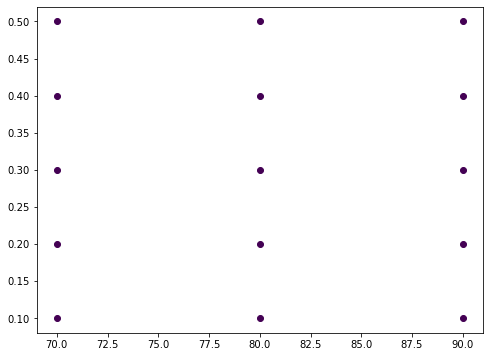

In [40]:
for i in range(len(accepted_inclinations)):
    for j in range(len(betas)):
        plt.scatter(accepted_inclinations[i], betas[j], c=reduced_chi_squared[i,j], cmap='viridis')